In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp


In [3]:
file = '../data/fs8Diagram.txt'
data = pd.read_csv(file, names=['z', '$f\sigma_8$', 'err', '$\Omega_ref$'], sep = "\t", skiprows=3)
data = data[['z', '$f\sigma_8$', 'err']]
# data.describe()
data

,z,$f\sigma_8$,err
0,0.020,0.4280,0.0465
1,0.020,0.3980,0.0650
2,0.020,0.3140,0.0480
3,0.100,0.3700,0.1300
4,0.150,0.4900,0.1450
5,0.170,0.5100,0.0600
6,0.180,0.3600,0.0900
7,0.380,0.4400,0.0600
8,0.250,0.3512,0.0583
9,0.370,0.4602,0.0378


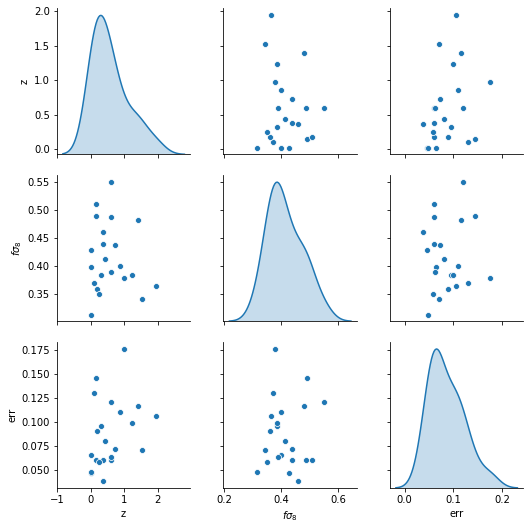

In [4]:
sns.pairplot(data, diag_kind="kde")
# plt.savefig("Distfs8.png")

In [5]:
# a= np.array([12,4,2,7,14,11,20,16,9,19,5,17,1,15,10,8,18,21,0,13,3,6])
# a = np.array([21,1,3,10,12,17,8,4,7,16, 2,11,19,13,18,5,9,20,15,14,6,0])
shuffle = [x for x in range(len(data.values)) if x%2 ==1]
even = [x for x in range(len(data.values)) if x%2 ==0]
shuffle.extend(even)
# randomize = np.random.permutation(len(data.values))
data = data.values[shuffle]
# array([17, 10,  1, 19, 12,  8, 14, 18,  4,  3,  6,  9, 21, 16,  2, 15,  0,
#        20,  7,  5, 11, 13])
# array([ 1, 15, 12, 20, 21,  3, 18, 13,  7, 19,  9,  8, 14,  6, 11,  4,  0,
#         5,  2, 10, 16, 17])

Read the data for cosmic chronometers

In [6]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [7]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [8]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [9]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=10)]
# initializer = Constant(value=0.01)
# initializer = RandomNormal()

In [10]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(50, activation='relu')(efirst)
    ehidden2 = Dense(50, activation='relu')(ehidden)
    elast = Dense(2, activation='relu')(ehidden2)
    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 7,902
Trainable params: 7,902
Non-trainable params: 0
_________________________________________________________________


In [11]:
# batch_size = 4
batch_size = 1
input_z = Input(shape = (1,))
epochs = 100

In [12]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0436 - val_loss: 0.0217
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0154 - val_loss: 0.0109
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0125 - val_loss: 0.0066
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0039
Epoch 5/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0034
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0053
Epoch 8/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 9/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 10/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0010
Epoch 11

Epoch 83/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 84/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 85/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 86/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 87/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 88/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 89/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 90/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 91/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 92/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0049


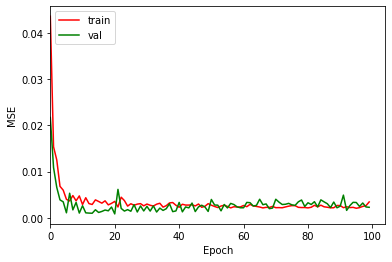

In [13]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("loss_fs8.png", dpi=200)
# plt.savefig("loss_epochs_fs8_1000.png", dpi=200)


In [14]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])
print(np.min(model_train.history['loss']), np.min(model_train.history['val_loss']))
# print(model_train.history['loss'][-1], model_train.history['val_loss'][-1])
# 0.0009567601955495775 0.0024885754100978374 mil epochs
# 0.0010785672347992659 0.0010806184727698565 500 epochs
# 0.0020020001102238894 0.0008378626080229878 100e
# 0.0021847975440323353 0.0009035465191118419 50e

0.0020537711679935455 0.0008289438555948436


In [15]:
pred = neural_model.predict(z_test)
pred

array([[0.44513825, 0.06389089],
       [0.47536016, 0.08515774],
       [0.45553023, 0.08072724],
       [0.42668962, 0.07878372],
       [0.40031967, 0.09477359]], dtype=float32)

In [16]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [17]:
ranz = np.random.uniform(0, 2, size=1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


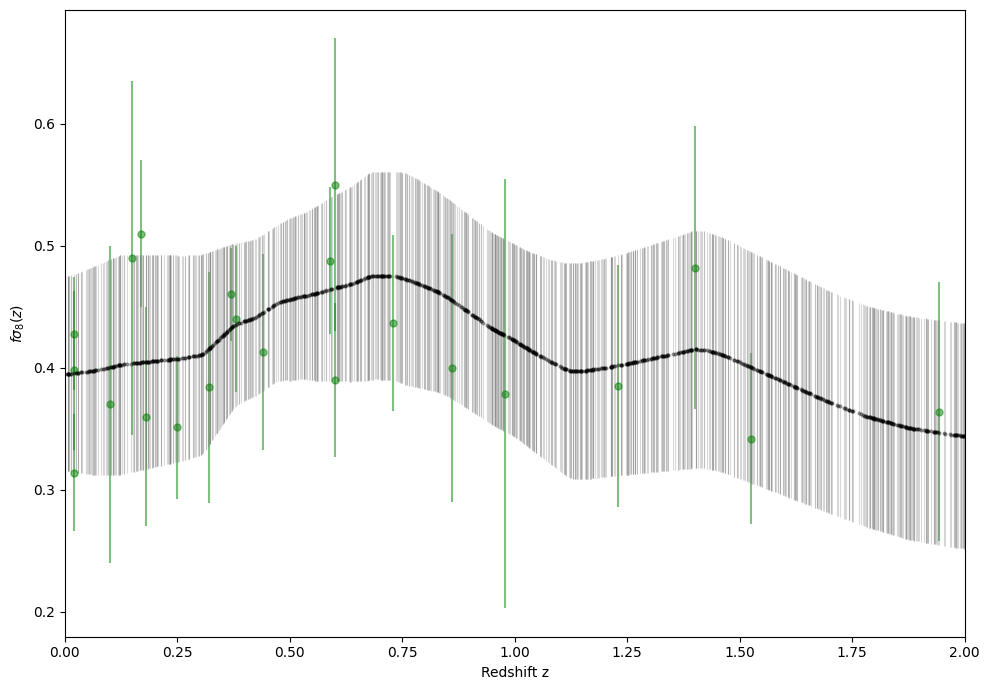

In [44]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='gray', capthick=2, elinewidth=0.8, alpha=0.3, c='k',)
plt.xlabel("Redshift z")
plt.ylabel("$f\sigma_8(z)$")
plt.xlim(0, 2)
plt.tight_layout()
# plt.legend(loc='upper right')
# plt.legend()
plt.savefig("synthetic_fs8_100mini.png")

In [19]:
from functools import partial
# Cosmological constants
Om = 0.27
# variance network
s8 = 0.8

In [20]:
def Ezlcdm(a):
    return np.sqrt(Om*(1/a)**3 + 1 - Om)

def RHSquared_a_lcdm(a):
        return Ezlcdm(a)**2
#     return Om*(1/a)**3 + 1 - Om

def integrate(fn, lower_bound, upper_array):
    r = np.zeros(len(upper_array))
    print(np.shape(r))
    for i in range(len(upper_array)):
        r[i] = upper_array[i]
#         intg.quad(fn, lower_bound, upper_array[i])
    return r

def growth(z):
    # Equation 7.77 from Doddie
    af = 1./(1. + z)
    try:
        r = integrate(GrowthIntegrand_a, 1e-7, af)
    except:
        r = integrate(GrowthIntegrand_a, 1e-7, (af,))
    gr = np.sqrt(RHSquared_a_lcdm(af))*r[0]  # assume precision is ok
    gr *= 5/2.*Om
    return gr
    


# returns the growth factor as a function of redshift
def GrowthIntegrand_a(a):
    return 1./(RHSquared_a_lcdm(a)*a*a)**(1.5)


def fs8(z):
    return -s8*(1+z)*derivative(growth, z, dx=1e-6, n=3)/growth(0)

# def Hlcdm(a, H0=73.24):
#     z = 1./a-1
#     return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

In [21]:
# z = np.linspace(0, 2, 100)
# fs8(z)
# # af = 1./(1.+z)
# # af

In [22]:
# z = np.linspace(0, 2, 100)
# plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)

# plt.plot(z, fs8(z), label='$\Lambda CDM$', c='b')
# plt.xlabel("Redshift z")
# plt.ylabel("$f\sigma_8(z)$")
# plt.xlim(0, 2)
# plt.tight_layout()
# plt.legend()

# plt.savefig("Syntheticfs8.png",dpi=800)

In [23]:
# pred_random.shape, r.shape

In [24]:
# randomselection = np.random.randint(0,1000,50)
randomselection = np.random.randint(0,1000,50)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [25]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)

# np.savetxt("annfs850_.dat",mookHz, delimiter=" ")

In [26]:
mookHz

array([[0.55067723, 0.46026963, 0.07041573],
       [1.69299282, 0.37299043, 0.09104864],
       [0.43041906, 0.44285893, 0.0640604 ],
       [0.20774528, 0.40587562, 0.08646736],
       [1.7976765 , 0.35862917, 0.09069625],
       [0.17016632, 0.4044314 , 0.08811019],
       [1.83769658, 0.35456166, 0.09113783],
       [0.63212842, 0.46824718, 0.07939167],
       [0.41510499, 0.44012034, 0.06450321],
       [1.184643  , 0.3992357 , 0.08932675],
       [0.79484873, 0.46763372, 0.0844735 ],
       [1.57775384, 0.39186025, 0.09359854],
       [0.24931448, 0.40747321, 0.08465008],
       [1.97514944, 0.34518975, 0.09226464],
       [0.53537227, 0.45904464, 0.06852435],
       [1.2499179 , 0.40349442, 0.09106904],
       [0.8191053 , 0.4639253 , 0.08283244],
       [0.85581702, 0.45658743, 0.08085991],
       [0.16239197, 0.4041326 , 0.08845007],
       [1.05755299, 0.4094387 , 0.08213488],
       [0.95059191, 0.43210781, 0.07872409],
       [0.94298907, 0.43390977, 0.07874277],
       [0.

In [27]:
predy_reduced[:,1]

array([0.07041573, 0.09104864, 0.0640604 , 0.08646736, 0.09069625,
       0.08811019, 0.09113783, 0.07939167, 0.06450321, 0.08932675,
       0.0844735 , 0.09359854, 0.08465008, 0.09226464, 0.06852435,
       0.09106904, 0.08283244, 0.08085991, 0.08845007, 0.08213488,
       0.07872409, 0.07874277, 0.07967248, 0.08632661, 0.07883953,
       0.09180257, 0.0962751 , 0.08274322, 0.09156582, 0.0920449 ,
       0.09203637, 0.09510267, 0.09151124, 0.09128754, 0.08854845,
       0.07090554, 0.09079202, 0.08886659, 0.08203077, 0.07443854,
       0.0798957 , 0.0908546 , 0.08493796, 0.08541199, 0.0795084 ,
       0.08502708, 0.07861848, 0.08211297, 0.08447772, 0.09011942],
      dtype=float32)

In [28]:
error  = predy_reduced[:,1]**2
error

array([0.00495837, 0.00828985, 0.00410373, 0.0074766 , 0.00822581,
       0.00776341, 0.0083061 , 0.00630304, 0.00416066, 0.00797927,
       0.00713577, 0.00876069, 0.00716564, 0.00851276, 0.00469559,
       0.00829357, 0.00686121, 0.00653833, 0.00782341, 0.00674614,
       0.00619748, 0.00620042, 0.0063477 , 0.00745228, 0.00621567,
       0.00842771, 0.00926889, 0.00684644, 0.0083843 , 0.00847226,
       0.00847069, 0.00904452, 0.00837431, 0.00833341, 0.00784083,
       0.0050276 , 0.00824319, 0.00789727, 0.00672905, 0.0055411 ,
       0.00638332, 0.00825456, 0.00721446, 0.00729521, 0.00632159,
       0.0072296 , 0.00618087, 0.00674254, 0.00713649, 0.00812151],
      dtype=float32)

In [29]:
diagcov = np.diag(error) #inverso
# np.savetxt("annfs8_cov50_.dat", diagcov, delimiter= " ", header="#50 50")
np.shape(diagcov)

(50, 50)

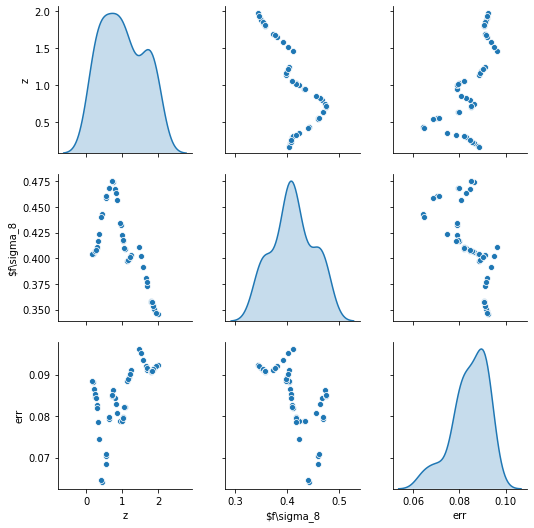

In [30]:
dfMook = pd.DataFrame(mookHz, columns=['z', '$f\sigma_8', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("dist50fs8fake_.png")

In [31]:
from astroNN.nn.layers import MCDropout

In [32]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((17, 1), (17, 1), (5, 1), (5, 1))

In [33]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100, 50, 50])
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=2000,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/2000
5/5 [==============================] - 0s 37ms/step - loss: 0.1129 - val_loss: 0.0992
Epoch 2/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.1009 - val_loss: 0.0853
Epoch 3/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.1008 - val_loss: 0.0972
Epoch 4/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0884 - val_loss: 0.1000
Epoch 5/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.0861 - val_loss: 0.0908
Epoch 6/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0870 - val_loss: 0.0749
Epoch 7/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0807 - val_loss: 0.0650
Epoch 8/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0795 - val_loss: 0.0540
Epoch 9/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0684 - val_loss: 0.0633
Epoch 10/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0679 - val_loss: 0.0678
Epoch 11/2000
5/5

5/5 [==============================] - 0s 10ms/step - loss: 0.0095 - val_loss: 0.0145
Epoch 84/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.0090 - val_loss: 0.0120
Epoch 85/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0130 - val_loss: 0.0134
Epoch 86/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 87/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0151 - val_loss: 0.0063
Epoch 88/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0097 - val_loss: 0.0096
Epoch 89/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0106
Epoch 90/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0086 - val_loss: 0.0061
Epoch 91/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0070 - val_loss: 0.0113
Epoch 92/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0083
Epoch 93/2000
5/5 [===

5/5 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0012
Epoch 166/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0056 - val_loss: 0.0071
Epoch 167/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0071 - val_loss: 0.0042
Epoch 168/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0045
Epoch 169/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 170/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0019
Epoch 171/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0078
Epoch 172/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 173/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 174/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0072
Epoch 175/2000


5/5 [==============================] - 0s 16ms/step - loss: 0.0043 - val_loss: 9.3680e-04
Epoch 248/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.0070 - val_loss: 0.0022
Epoch 249/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 250/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0058 - val_loss: 0.0062
Epoch 251/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 252/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 253/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.0041 - val_loss: 0.0074
Epoch 254/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.0052 - val_loss: 0.0038
Epoch 255/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 256/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch

Epoch 329/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0024
Epoch 330/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 331/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0039
Epoch 332/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 333/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0053
Epoch 334/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 335/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 336/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 337/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 0.0054
Epoch 338/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0043

Epoch 411/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0029
Epoch 412/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 413/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0021
Epoch 414/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 415/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 416/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 417/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 418/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 419/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 420/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0023


Epoch 493/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 494/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 495/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 496/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 497/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0035 - val_loss: 0.0069
Epoch 498/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 499/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 500/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0039 - val_loss: 0.0049
Epoch 501/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 502/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0051 - val_loss: 0.0045


5/5 [==============================] - 0s 9ms/step - loss: 0.0057 - val_loss: 0.0030
Epoch 575/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 576/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 577/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 578/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 579/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 580/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 581/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 582/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 583/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0037 - val_loss: 0.0072
Epoch 584/2

5/5 [==============================] - 0s 8ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 657/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0064
Epoch 658/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 659/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0042
Epoch 660/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0054 - val_loss: 0.0025
Epoch 661/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 662/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 663/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 664/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 665/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0015
Epoch 666/2000


5/5 [==============================] - 0s 11ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 739/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 740/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 741/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 742/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0086 - val_loss: 0.0042
Epoch 743/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.0048 - val_loss: 0.0031
Epoch 744/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 745/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 746/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 747/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 748

Epoch 820/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 821/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 822/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 823/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 824/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 825/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 826/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 827/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 828/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0055 - val_loss: 0.0026
Epoch 829/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.0048 - val_loss: 0.0040

5/5 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 902/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 903/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 904/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 905/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 906/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0048
Epoch 907/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 908/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 909/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 910/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 911/2000

5/5 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 984/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 985/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 986/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 987/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 988/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 989/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 990/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.0032
Epoch 991/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 992/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 993/2000


5/5 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 1065/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0035
Epoch 1066/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.0049
Epoch 1067/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 1068/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 1069/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 1070/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 1071/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 1072/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 1073/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 

5/5 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 1146/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 1147/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 1148/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 1149/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 1150/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 1151/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 1152/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 1153/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 1154/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.0027 - val_loss: 0.0024


Epoch 1226/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 1227/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 1228/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 1229/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 1230/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 1231/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 1232/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 1233/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 1234/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 9.5165e-04
Epoch 1235/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0023 - val

Epoch 1307/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 1308/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 1309/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 1310/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 1311/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 1312/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 1313/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 1314/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 1315/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 1316/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0035 - val_los

5/5 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 1389/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 1390/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 1391/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 1392/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0057
Epoch 1393/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 1394/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 1395/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 1396/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 1397/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch

5/5 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 1470/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 1471/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 1472/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 1473/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 1474/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 1475/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 1476/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 1477/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 1478/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 

5/5 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 1551/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 1552/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 1553/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 1554/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 1555/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 1556/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 1557/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 1558/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 1559/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch

5/5 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 1632/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 1633/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 1634/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 1635/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 1636/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 1637/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 1638/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 1639/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 1640/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 1713/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 1714/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 1715/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 1716/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 1717/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 1718/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 1719/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 1720/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 1721/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0044
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 1793/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1794/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1795/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 1796/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 1797/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0055
Epoch 1798/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 1799/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 1800/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 1801/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 1874/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 1875/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 1876/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 1877/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 1878/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 1879/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 1880/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0038
Epoch 1881/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 1882/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 1955/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 1956/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 1957/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 1958/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 1959/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 1960/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 1961/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 1962/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 1963/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0045
Epoch 

In [45]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [46]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(0.03245395519265156, 0.01446181218780831)

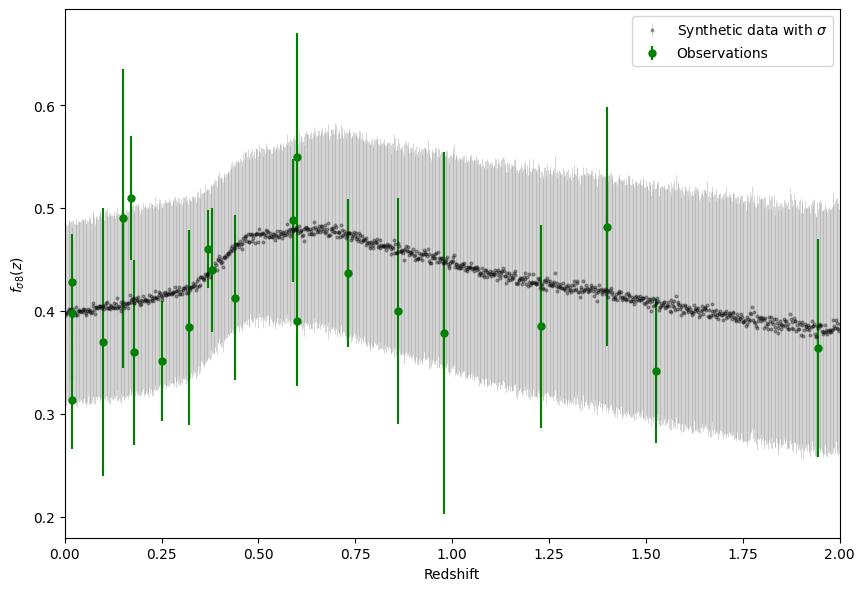

In [47]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='gray', capthick=2, elinewidth=0.8, alpha=0.3, c='k',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0,2)
plt.xlabel('Redshift')
plt.ylabel('$f_{\sigma8}(z)$')
# plt.legend(loc='best')
plt.legend(loc='upper right')
# plt.show()
# plt.savefig('fs8_dropout.png', dpi=100)

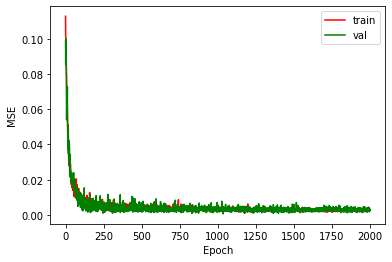

In [48]:
plt.plot(model2_train.history['loss'], color='r')
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.legend(['train', 'val'], loc='upper right')
# plt.savefig('lossfs8dropout.png', dpi=100)

In [49]:
mookdpfs8 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("annfs850dropout.dat",mookdpfs8, delimiter=" ")

In [50]:
diagcov2 = np.diag(sigma**2) #inverso
# np.savetxt("annfs8_cov50dropout.dat", diagcov2, delimiter= " ", header="#50 50")

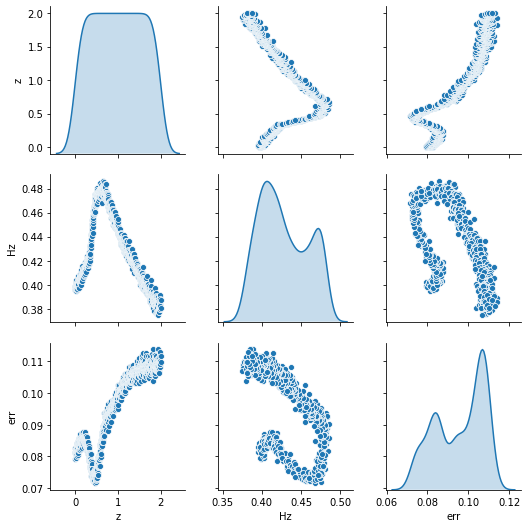

In [51]:
dfMook = pd.DataFrame(mookdpfs8, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50fs8dmookdropout.png")